# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Section 1: Business Understanding

### Import required packages.

In [1282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
from datetime import datetime

%matplotlib inline

# Section 2: Data Exploration

### Read in the datasets.

In [1283]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Create a function to summarize the details of each dataset.

In [1284]:
# Define a function to answer: How large is the dataset? How many null values are there? What proportion of nulls? What are the column types?
def df_info(df):
    '''
    Determine the size and shape of the dataset, the number and proportion of null values in each column, and the data type in each column.
    ARGS: 
    df - dataframe of interest
    OUTPUTS: 
    A string containing the Shape of the dataframe followed by a line for each column containing the 
    column name: number of null values, proportion of null values, and column type.
    '''
    print("Head:")
    print(df.head())
    print()
    print("Shape: " + "\n" + str(df.shape))
    print()
    print("Column Info:")
    for column in df.columns:
        num_null = df[column].isnull().sum()
        prop_null = df[column].isnull().mean()
        col_type = df[column].dtype
        try:
            nunique = df[column].nunique()
        except TypeError:
            nunique = 'cannot compute for this data type'
        print("    " + column + "\n" + "        " + str(num_null) + " nulls, proportion of nulls = " + 
              str(prop_null) + ", type = " + str(col_type) + ", nunique = " + str(nunique))
    print("\n" + "Descriptive Statistics:")
    print(df.describe())

### Explore the portfolio dataset.

In [1285]:
df_info(portfolio)

Head:
   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  

Shape: 
(10, 6)

Column Info:
    reward
        0 nulls, proportion of nulls = 0.0, type = int64, nunique = 5
    channels
        0 nulls, proportion of nulls = 0.0, type = object, nunique = cannot compute for this data type
    difficulty
        0 nulls, proportion of nulls = 0.0

In [1286]:
# portfolio.value_counts()

That throws an error, because it looks like the "channels" column is a list. Let's see what we get if we ignore the "channels" column for now. We will need to work around this list in Section 3.

In [1287]:
portfolio[['reward', 'difficulty', 'duration', 'offer_type', 'id']].groupby('offer_type').value_counts()

offer_type     reward  difficulty  duration  id                              
bogo           5       5           5         f19421c1d4aa40978ebb69ca19b0e20d    1
                                   7         9b98b8c7a33c4b65b9aebfe6a799e6d9    1
               10      10          5         4d5c57ea9a6940dd891ad53e9dbe8da0    1
                                   7         ae264e3637204a6fb9bb56bc8210ddfd    1
discount       2       10          7         2906b810c7d4411798c6938adc9daaa5    1
                                   10        fafdcd668e3743c1bb461111dcafc2a4    1
               3       7           7         2298d6c36e964ae4a3e7e9706d1fb8c2    1
               5       20          10        0b1e1539f2cc45b7b9fa7c272da2e1d7    1
informational  0       0           3         5a8bc65990b245e5a138643cd4eb9837    1
                                   4         3f207df678b143eea3cee63160fa8bed    1
Name: count, dtype: int64

Let's visualize some of this. Do higher difficulty offers also tend to have a higher reward?

Text(0, 0.5, 'Reward ($)')

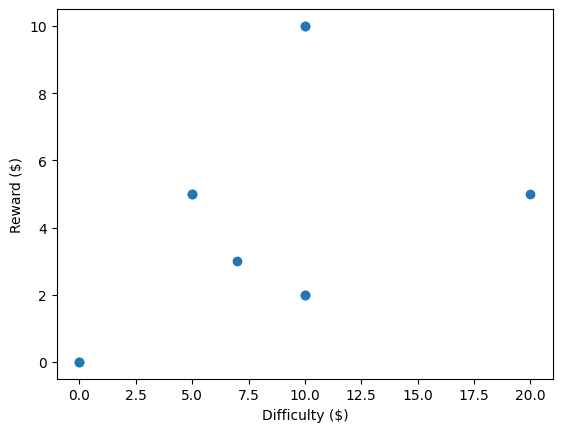

In [1288]:
plt.scatter(portfolio['difficulty'], portfolio['reward']);
plt.xlabel('Difficulty ($)')
plt.ylabel('Reward ($)')

There does appear to be some positive correlation, though this is a very small sample size and the correlation does not appear particularly strong.

### Explore the profile dataset.

In [1289]:
df_info(profile)

Head:
  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

Shape: 
(17000, 5)

Column Info:
    gender
        2175 nulls, proportion of nulls = 0.12794117647058822, type = object, nunique = 3
    age
        0 nulls, proportion of nulls = 0.0, type = int64, nunique = 85
    id
        0 nulls, proportion of nulls = 0.0, type = object, nunique = 17000
    became_member_on
        0 nulls, proportion of nulls = 0.0, type = int64, nunique = 1716
    income
        2175 nulls, proportion of nulls = 0.12794117647058822, type = float64, nunique = 91

Descriptive Statistics:
                age 

2,175 nulls for both gender and income. Is it the same people with null values in both fields?

In [1290]:
nulls = profile[profile[['gender', 'income']].isnull().all(axis=1)]
print(nulls.shape)
nulls.head()

(2175, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


It looks like the same 2,175 people have null values for gender and income. Perhaps these people generally prefer to report as little data as possible. It may be interesting to look at this group more critically when assessing the effectiveness of the offers. If we decide to model later on, we may also choose to impute these data points in Section 3.

How many users are there in each gender group?

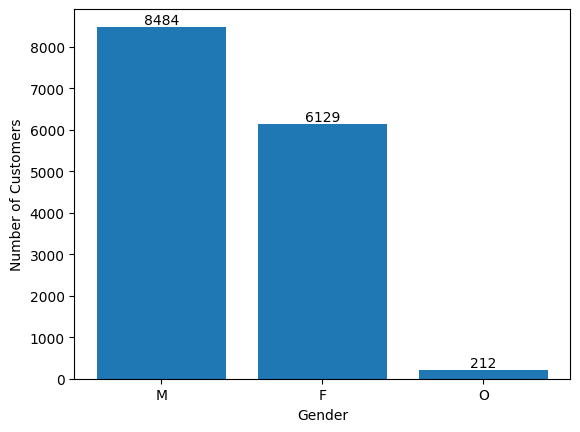

In [1291]:
gender_counts = profile['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
for i in range(len(gender_counts.index)):
    plt.text(i, gender_counts.values[i], str(gender_counts.values[i]), ha='center', va='bottom')

There are 2,355 more male than female users and only 212 users that identify as 'Other'.

What about age? In the descriptive statistics above, the max age is 118. That seems high. 

Text(0, 0.5, 'Frequency')

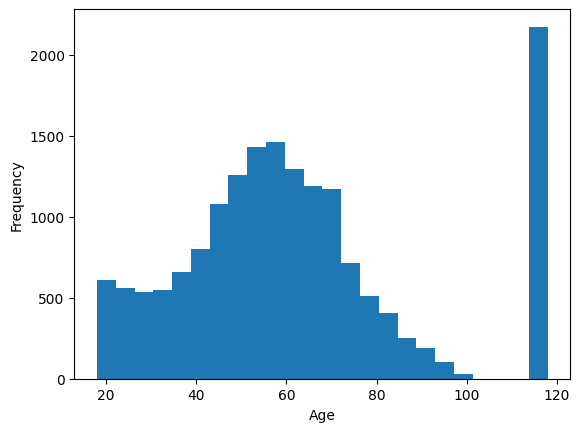

In [1292]:
plt.hist(profile['age'], bins=24)
plt.xlabel('Age')
plt.ylabel('Frequency')

The highest frequency age is around 118. That seems highly unusual and unlikely. What are the age ranges allowed in the app? Perhaps these users selected the oldest age possible as a way to maintain privacy around their true age. Exactly how many users listed age as 118?

In [1293]:
(profile['age']== 118).sum()

np.int64(2175)

Odd...there are 2175 users with age 118. That's the same number of users with null values for gender and income. Is it the same 2175 users?

In [1294]:
((profile['age']== 118) & (profile[['gender', 'income']].isnull().all(axis=1))).sum()

np.int64(2175)

The same 2,175 users with null gender and income have listed age as 118. These users may be reluctant to share their real information. How does that translate to their likelihood to engage with offers?

In the next section, we'll make a dataframe of just these users for further exploration. 

Of the reasonable ages reported, the largest number of users appear to be in the 50-60 year old range. The average given above was 62, but we know that is skewed high due to the number of users reporting an age of 118. 

Let's take a look at the income distribution. From above, we know that the average income is about $65,405 with a minimum of $30,000 and a maximum of $120,000. 

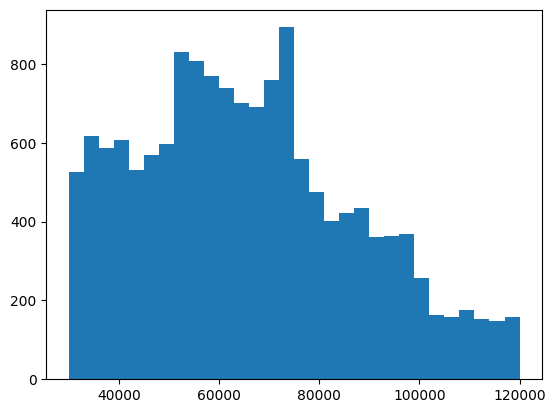

In [1295]:
plt.hist(profile['income'], bins=30);

Most users make less than $80,000 and there are no obvious outliers here. 

### Explore the transcript dataset.

In [1296]:
df_info(transcript)

Head:
                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  

Shape: 
(306534, 4)

Column Info:
    person
        0 nulls, proportion of nulls = 0.0, type = object, nunique = 17000
    event
        0 nulls, proportion of nulls = 0.0, type = object, nunique = 4
    value
        0 nulls, proportion of nulls = 0.0, type = object, nunique = cannot compute for thi

In [1297]:
# transcript.value_counts()

The above line of code throws an error due to the 'value' field being a dictionary. Let's try again, ignoring the 'value' field for the time being. We will need to work around this dictionary in Section 3.

In [1298]:
events = transcript['event'].value_counts()

Let's visualize that.

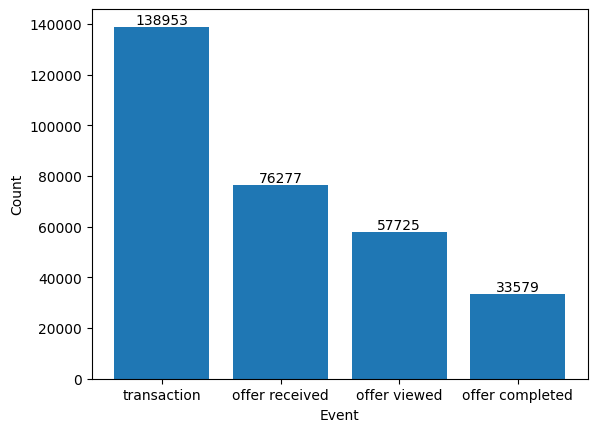

In [ ]:
plt.bar(events.index, events.values)
plt.xlabel('Event')
plt.ylabel('Count')
for i in range(len(events.index)):
    plt.text(i, events.values[i], str(events.values[i]), ha='center', va='bottom')

There are significantly more transactions than offers received, viewed, and completed. This is in line with what we would expect given that many users will buy regardless of potential offers. 

## Section 3: Data Preparation

#### Portfolio Dataset:

Rename fields to reflect these are characteristics of the offer to prevent confusion later on.

In [1300]:
portfolio = portfolio.rename(columns = {'id': 'offer_id', 'reward': 'offer_reward', 'difficulty': 'offer_difficulty', 'duration': 'offer_duration'})

In the portfolio dataset, the 'channels' field is a list. Let's break each component of the list into separate columns so that they are easier to work with. 

In [1301]:
# Explode the list into rows
portfolio_exploded = portfolio.explode('channels')

# Create dummy variables (binary columns)
portfolio_dummies = pd.get_dummies(portfolio_exploded, columns=['channels'], prefix='', prefix_sep='')

# Aggregate back to original rows, keeping max value (1 if present, 0 if not)
portfolio_new = portfolio_dummies.groupby(portfolio_dummies.index).max()

# Print result
print(portfolio_new)

   offer_reward  offer_difficulty  offer_duration     offer_type  \
0            10                10               7           bogo   
1            10                10               5           bogo   
2             0                 0               4  informational   
3             5                 5               7           bogo   
4             5                20              10       discount   
5             3                 7               7       discount   
6             2                10              10       discount   
7             0                 0               3  informational   
8             5                 5               5           bogo   
9             2                10               7       discount   

                           offer_id  email  mobile  social    web  
0  ae264e3637204a6fb9bb56bc8210ddfd   True    True    True  False  
1  4d5c57ea9a6940dd891ad53e9dbe8da0   True    True    True   True  
2  3f207df678b143eea3cee63160fa8bed   True    T

#### Profile Dataset:

Rename 'id' to 'customer_id' for clarity. 

In [1302]:
profile = profile.rename(columns = {'id': 'customer_id'})

The profile dataset has 'became_member_on' categorized as an integer field. Let's correct it to a date field. 

In [1303]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

Now let's visualize membership join dates. 

In [1304]:
# Extract the full date (YYYY-MM-DD), year-month (YYYY-MM), and month (MM)
profile['member_join_year'] = profile['became_member_on'].dt.strftime('%Y')
profile.head()

,gender,age,customer_id,became_member_on,income,member_join_year
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017


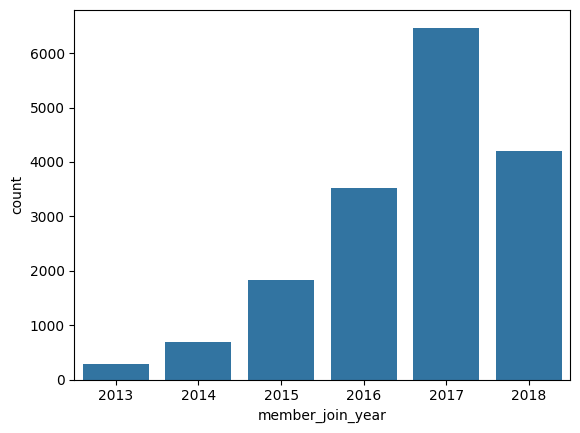

In [1305]:
sns.countplot(data = profile, x = 'member_join_year', order = profile.sort_values(['member_join_year'], ascending=True).set_index('member_join_year').index);

It looks like new memberships increased year over year from 2013 to a peak in 2017, followed by fewer new members in 2018. 

Let's make a dataframe of the profiles with null gender and income and age 118.

In [1306]:
null_profiles = profile[(profile['age']== 118) & (profile['gender'].isnull()) & (profile['income'].isnull())]
print(null_profiles.head())
null_profiles.shape

  gender  age                       customer_id became_member_on  income  \
0   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12     NaN   
2   None  118  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12     NaN   
4   None  118  a03223e636434f42ac4c3df47e8bac43       2017-08-04     NaN   
6   None  118  8ec6ce2a7e7949b1bf142def7d0e0586       2017-09-25     NaN   
7   None  118  68617ca6246f4fbc85e91a2a49552598       2017-10-02     NaN   

  member_join_year  
0             2017  
2             2018  
4             2017  
6             2017  
7             2017  


(2175, 6)

#### Transcript Dataset:

Rename 'person' to 'customer_id' to align with the profile dataset. 

In [1307]:
transcript = transcript.rename(columns = {'person': 'customer_id'})

In the transcript dataset, 'value' is a dictionary. Let's break that up to be more workable.

First, notice that the dictionary has two different keys indicating the same thing: 'offer id' and 'offer_id'. Let's correct the keys so that there is only one version: 'offer_id'. 

In [1308]:
# Function to correct the key 'offer id' to 'offer_id'
def correct_key(dictionary):
    if 'offer id' in dictionary:
        dictionary['offer_id'] = dictionary.pop('offer id')
    return dictionary

In [1309]:
# Apply the function to the dictionary column
transcript['value'] = transcript['value'].apply(correct_key)

Let's expand the dictionary 'value' column into multiple columns representing each key and the respective values. We will keep the original 'value' column for reference. 

In [1310]:
# Function to expand dictionary into columns
def expand_dict_columns(df, column_name):
    new_cols = df[column_name].apply(pd.Series)
    df = pd.concat([df, new_cols], axis=1)
    #df = df.drop(column_name, axis=1)
    return df

# Expand the 'details' column
transcript_new = expand_dict_columns(transcript, 'value')

# Display the modified DataFrame
transcript_new

,customer_id,event,value,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,NaN,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,NaN,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,NaN,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,NaN,3.53,NaN


Rename 'reward' to 'reward_earned' to differentiate from 'reward' in the portfolio dataset.

In [1311]:
transcript_new = transcript_new.rename(columns = {'reward': 'reward_earned'})
transcript_new.head() # confirm change was successful

,customer_id,event,value,time,offer_id,amount,reward_earned
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


#### Combine datasets into one dataframe.

In [1312]:
full_df = pd.merge(transcript_new, profile, how = 'left', on = 'customer_id')
full_df.head()

,customer_id,event,value,time,offer_id,amount,reward_earned,gender,age,became_member_on,income,member_join_year
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,2017-05-09,100000.0,2017
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,None,118,2017-08-04,NaN,2017
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,M,68,2018-04-26,70000.0,2018
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,None,118,2017-09-25,NaN,2017
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,None,118,2017-10-02,NaN,2017


In [1313]:
full_df = pd.merge(full_df, portfolio_new, how = 'left', on = 'offer_id')
full_df.head()

,customer_id,event,value,time,offer_id,amount,reward_earned,gender,age,became_member_on,income,member_join_year,offer_reward,offer_difficulty,offer_duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,2017-05-09,100000.0,2017,5.0,5.0,7.0,bogo,True,True,False,True
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,None,118,2017-08-04,NaN,2017,5.0,20.0,10.0,discount,True,False,False,True
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,M,68,2018-04-26,70000.0,2018,2.0,10.0,7.0,discount,True,True,False,True
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,None,118,2017-09-25,NaN,2017,2.0,10.0,10.0,discount,True,True,True,True
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,None,118,2017-10-02,NaN,2017,10.0,10.0,5.0,bogo,True,True,True,True


In [1155]:
df_info(full_df)

Head:
                        customer_id           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  \
0  {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0   
1  {'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   
2  {'offer_id': '2906b810c7d4411798c6938adc9daaa5'}     0   
3  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   
4  {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   

                           offer_id  amount  reward_earned gender  age  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN            NaN      F   75   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN            NaN   None  118   
2  2906b810c7d4411798c6938adc9daaa5     NaN            NaN      M   68   


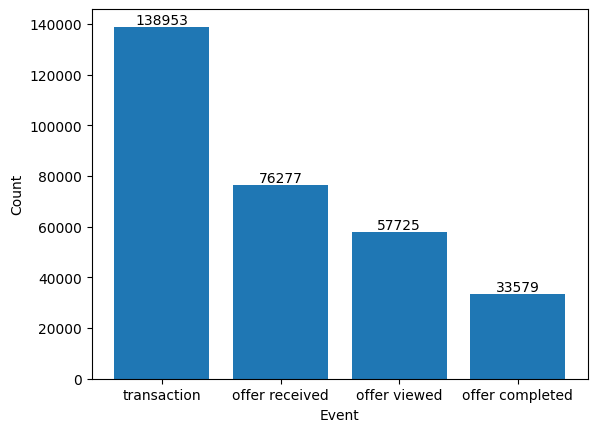

In [1321]:
events_all = full_df['event'].value_counts()
plt.bar(events_all.index, events_all.values)
plt.xlabel('Event')
plt.ylabel('Count')
for i in range(len(events_all.index)):
    plt.text(i, events_all.values[i], str(events_all.values[i]), ha='center', va='bottom')

In [1352]:
all_ratio_completed_v_all_events = events_all['offer completed'] / full_df.shape[0]
all_ratio_completed_v_all_events

np.float64(0.10954412887314295)

When looking at the entire dataset, about 11% of events are offer completions. 

What if we look at only the portion of users with complete profiles?

In [1368]:
complete_profiles = profile[(profile['gender'].notnull()) & (profile['income'].notnull())]
print(complete_profiles.head())
complete_profiles.shape

   gender  age                       customer_id became_member_on    income  \
1       F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   
3       F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0   
5       M   68  e2127556f4f64592b11af22de27a7932       2018-04-26   70000.0   
8       M   65  389bc3fa690240e798340f5a15918d5c       2018-02-09   53000.0   
12      M   58  2eeac8d8feae4a8cad5a6af0499a211d       2017-11-11   51000.0   

   member_join_year  
1              2017  
3              2017  
5              2018  
8              2018  
12             2017  


(14825, 6)

In [1375]:
complete_df = pd.merge(transcript_new, complete_profiles, how = 'inner', on = 'customer_id')
complete_df.head()

,customer_id,event,value,time,offer_id,amount,reward_earned,gender,age,became_member_on,income,member_join_year
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,2017-05-09,100000.0,2017
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,M,68,2018-04-26,70000.0,2018
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,M,65,2018-02-09,53000.0,2018
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer_id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,M,58,2017-11-11,51000.0,2017
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,F,61,2017-09-11,57000.0,2017


In [1383]:
complete_df = pd.merge(complete_df, portfolio_new, how = 'inner', on = 'offer_id')
complete_df.head()

,customer_id,event,value,time,offer_id,amount,reward_earned,gender,age,became_member_on,income,member_join_year,offer_reward,offer_difficulty,offer_duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,2017-05-09,100000.0,2017,5,5,7,bogo,True,True,False,True
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,M,68,2018-04-26,70000.0,2018,2,10,7,discount,True,True,False,True
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,M,65,2018-02-09,53000.0,2018,5,5,5,bogo,True,True,True,True
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer_id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,M,58,2017-11-11,51000.0,2017,0,0,4,informational,True,True,False,True
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,F,61,2017-09-11,57000.0,2017,5,20,10,discount,True,False,False,True


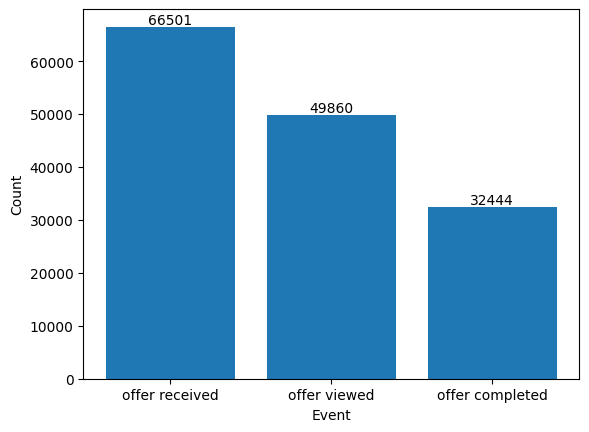

In [1391]:
events_complete = complete_df['event'].value_counts()
plt.bar(events_complete.index, events_complete.values)
plt.xlabel('Event')
plt.ylabel('Count')
for i in range(len(events_complete.index)):
    plt.text(i, events_complete.values[i], str(events_complete.values[i]), ha='center', va='bottom')

In [1398]:
complete_ratio_completed_v_all_events = events_complete['offer completed'] / complete_df.shape[0]
complete_ratio_completed_v_all_events

np.float64(0.2180303081213669)

Wow! When looking at only complete profiles, the percentage of all events representing offer completions is 21.8%!

Let's compare with our dataframe of null profiles. 

In [1399]:
null_df = pd.merge(transcript_new, null_profiles, how = 'inner', on = 'customer_id')
null_df.head()

,customer_id,event,value,time,offer_id,amount,reward_earned,gender,age,became_member_on,income,member_join_year
0,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,None,118,2017-08-04,NaN,2017
1,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,None,118,2017-09-25,NaN,2017
2,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,None,118,2017-10-02,NaN,2017
3,c4863c7985cf408faee930f111475da3,offer received,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,None,118,2017-08-24,NaN,2017
4,744d603ef08c4f33af5a61c8c7628d1c,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,None,118,2017-08-01,NaN,2017


In [1400]:
null_df = pd.merge(null_df, portfolio_new, how = 'left', on = 'offer_id')
null_df.head()

,customer_id,event,value,time,offer_id,amount,reward_earned,gender,age,became_member_on,income,member_join_year,offer_reward,offer_difficulty,offer_duration,offer_type,email,mobile,social,web
0,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,None,118,2017-08-04,NaN,2017,5.0,20.0,10.0,discount,True,False,False,True
1,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,None,118,2017-09-25,NaN,2017,2.0,10.0,10.0,discount,True,True,True,True
2,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,None,118,2017-10-02,NaN,2017,10.0,10.0,5.0,bogo,True,True,True,True
3,c4863c7985cf408faee930f111475da3,offer received,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,None,118,2017-08-24,NaN,2017,3.0,7.0,7.0,discount,True,True,True,True
4,744d603ef08c4f33af5a61c8c7628d1c,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,None,118,2017-08-01,NaN,2017,5.0,20.0,10.0,discount,True,False,False,True


In [1401]:
df_info(null_df)

Head:
                        customer_id           event  \
0  a03223e636434f42ac4c3df47e8bac43  offer received   
1  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
2  68617ca6246f4fbc85e91a2a49552598  offer received   
3  c4863c7985cf408faee930f111475da3  offer received   
4  744d603ef08c4f33af5a61c8c7628d1c  offer received   

                                              value  time  \
0  {'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   
1  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   
2  {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   
3  {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}     0   
4  {'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   

                           offer_id  amount  reward_earned gender  age  \
0  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN            NaN   None  118   
1  fafdcd668e3743c1bb461111dcafc2a4     NaN            NaN   None  118   
2  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN            NaN   None  118   


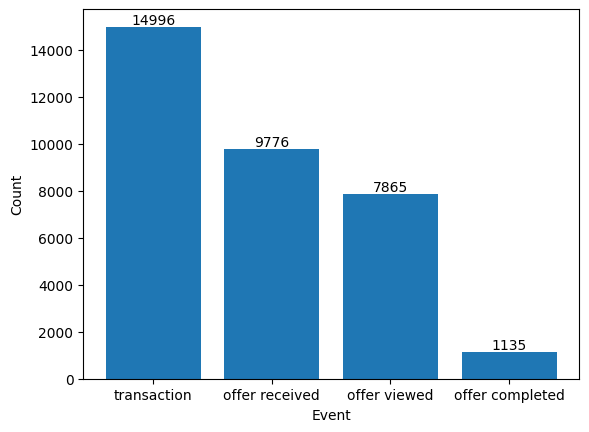

In [1402]:
events_null = null_df['event'].value_counts()
plt.bar(events_null.index, events_null.values)
plt.xlabel('Event')
plt.ylabel('Count')
for i in range(len(events_null.index)):
    plt.text(i, events_null.values[i], str(events_null.values[i]), ha='center', va='bottom')

In [1403]:
null_ratio_completed_v_all_events = events_null['offer completed'] / null_df.shape[0]
null_ratio_completed_v_all_events

np.float64(0.0336077223735639)

When looking at only users with null profiles, only about 3.4% of events are offer completions. Clearly there is a big difference in offer engagement for null profiles vs completed profiles. Let's add a column into our full_df to indicate whether a profile is complete or not.

In [1417]:
full_df['profile_complete'] = np.where(full_df['age'] == 118, 0, 1)
full_df.head()

,customer_id,event,value,time,offer_id,amount,reward_earned,gender,age,became_member_on,...,member_join_year,offer_reward,offer_difficulty,offer_duration,offer_type,email,mobile,social,web,profile_complete
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,2017-05-09,...,2017,5.0,5.0,7.0,bogo,True,True,False,True,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,None,118,2017-08-04,...,2017,5.0,20.0,10.0,discount,True,False,False,True,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,M,68,2018-04-26,...,2018,2.0,10.0,7.0,discount,True,True,False,True,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,None,118,2017-09-25,...,2017,2.0,10.0,10.0,discount,True,True,True,True,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,None,118,2017-10-02,...,2017,10.0,10.0,5.0,bogo,True,True,True,True,0


## Section 4: Data Modeling

Questions posed:
1. Does one gender take greater advantage of offers than another?
2. Does one age group take advantage of more offers?
3. Do newer members take advantage of more offers?
4. Do higher reward offers tend to be utilized more than lower reward offers?
5. Are higher difficulty offers utilized less than lower difficulty offers?
6. Do higher income individuals use more or less offers?
7. What type of offer is used more?
8. Do longer duration offers get used more?
9. What is the average spend in the transcript dataset?

Aim

We want to predict whether a customer will complete an offer (like buying a product or using a discount) when they receive a promotion. The question is whether the customer will take action (complete the offer) or not (ignore the offer). This is a classification problem because we're trying to categorize the outcome into one of two possible categories: "Offer Completed" or "Offer Not Completed".

Algorithms we'll use:

Random Forest: This method builds multiple models (called decision trees) and combines their predictions. It’s like asking a group of decision-makers and taking the majority opinion. It's good for making accurate predictions even when data is complex.

Naive Bayes: This algorithm is based on probability. It looks at the features (like age, income, etc.) of a customer and calculates how the probability that the customer will complete the offer. It assumes that each feature is independent of the others (which is why it's called "naive").

Logistic Regression: Classification method. It looks at the relationship between the features and the outcome, using an equation to predict the probability of a customer completing the offer.

Decision Tree: A decision tree is like a flowchart. It asks questions about the features (like "Is the customer over 30 years old?") and makes decisions based on answers. The tree keeps branching out until it classifies the customer as either completing or not completing the offer.

Support Vector Machines (SVM): This algorithm tries to find the "best line" (or hyperplane) that divides the data into two classes (completed offer vs. not completed offer). It tries to maximize the margin between the classes. It's powerful for handling complex data, especially when the classes are not clearly separable.

K-Nearest Neighbors (KNN): This algorithm looks at the closest data points (neighbors) to a customer and classifies the customer based on what most of the neighbors did. For example, if most nearby customers completed the offer, the new customer is likely to complete it too.



Steps We Will Take

Modeling: First, we'll try all of these algorithms and see which one performs the best (example, gives us the highest accuracy at predicting whether a customer will complete an offer). This gives us a starting point.

Improving the Best Model: Once we identify the best model (the one with the highest accuracy), we’ll improve it further. One way to do this is through hyperparameter tuning, which means adjusting the settings of the model to make it more accurate.

Each algorithm has its own strengths and is good for different types of data or problems, so we’ll test them all to see which works best for our specific case.

In [ ]:
# Select features
X = df[['difficulty','reward','email','mobile','social','web','bogo','discount','informational','female','male','other_gender','age_bins','income_bins' ,'member_year','member_month']]

# Define the target variable we want to predict
y = df['event_result'].ravel()

# Split data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state=42)

NameError: name 'df' is not defined

## Section 5: Evaluate the Results